In [10]:
import numpy as np
from numpy import linalg as LA
from scipy.optimize import root
from wolframclient.evaluation import WolframLanguageSession
from wolframclient.language import wl, wlexpr
from itertools import combinations
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.colors as colors
import csv
import pandas as pd
from scipy.stats import norm

# define matplotlib style
mpl.style.use("classic")
mpl.rc("xtick", labelsize=15)
mpl.rc("ytick", labelsize=15)
mpl.rc("xtick.major", size=14, width=2)
mpl.rc("xtick.minor", size=7, width=2, visible=True)
mpl.rc("ytick.major", size=14, width=2)
mpl.rc("ytick.minor", size=7, width=2, visible=True)
mpl.rc("lines", linewidth=2, markersize=5)
mpl.rc("axes", linewidth=2, labelsize=15, labelpad=2.5)
mpl.rc("legend", fontsize=15, loc="best", frameon=True, numpoints=1)

mpl.rc("font", family="STIXGeneral")
mpl.rc("mathtext", fontset="stix")
mpl.rc("axes", titlesize=20, titlepad=10)

/var/folders/1r/x7pmt5qs61j4zkk17bl3rg0m0000gn/T/ipykernel_3047/45129402.py:7: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv('/Users/yongao/Desktop/8.13/mit-jlab-sp25/tasks/x1/x1.2/long_data/maxborn.txt', delim_whitespace=True, comment='#', header=None)


   0        1         2     3      4      5      6      7          8      9   \
0   1  0:00:09  1/1/2019   209  128.0    8.0   7.38  23.98  102714.59  50546   
1   2  0:00:09  1/1/2019   266  976.0  336.0  63.33  23.98  102714.59   4791   
2   3  0:00:09  1/1/2019   976  115.0    9.0   7.01  23.98  102714.93  52391   
3   4  0:00:11  1/1/2019  2021  830.0   56.0  23.16  23.98  102715.26  52388   
4   5  0:00:11  1/1/2019  2062  698.0   12.0  15.65  23.98  102715.26   1848   

   10  
0   0  
1   0  
2   0  
3   0  
4   0  


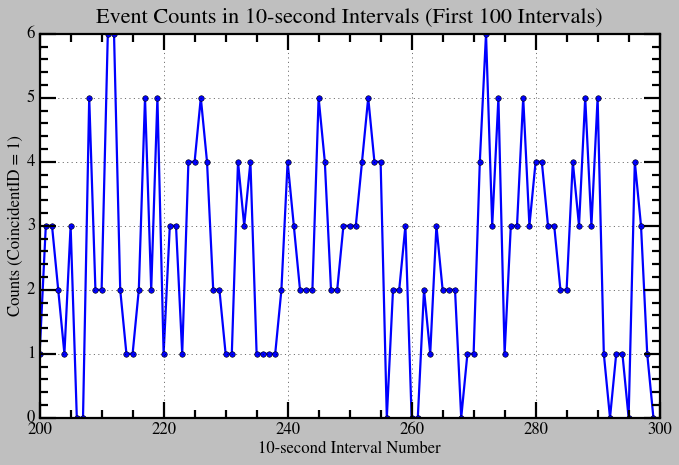

Mean counts per interval: 2.55
Jitter (standard deviation): 1.5723301886761005


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Read the data file.
# We assume that header lines starting with '#' should be skipped.
# Adjust the filename ('FileC013.txt') if necessary.
df = pd.read_csv('/Users/yongao/Desktop/8.13/mit-jlab-sp25/tasks/x1/x1.2/long_data/maxborn.txt', delim_whitespace=True, comment='#', header=None)

# Assign column names based on the file documentation:
# Columns: EventNumber, Time, Date, TimeStamp[ms], ADC1, ADC2, SiPM[mV],
# Temp[C], Pressure[Pa], DeadTime[us], CoincidentID, Device
print(df.head())

df.columns = ['EventNumber', 'Time', 'Date', 'TimeStamp_ms', 'ADC1', 'ADC2',
'SiPM_mV', 'Temp_C', 'Pressure_Pa', 'DeadTime_us', 'CoincidentID']

# Convert the 'Time' column (formatted like '0:00:07') to seconds
df['Seconds'] = pd.to_timedelta(df['Time']).dt.total_seconds()

# Create a new column with the 10-second interval index (starting at 0)
df['Interval'] = (df['Seconds'] // 10).astype(int)

# Filter the rows to include only events with CoincidentID == 1
df_coinc = df[df['CoincidentID'] == 1]

# Count events per interval for intervals 0 through 99 (first 100 intervals)
# Group by the 'Interval' column
counts = df_coinc[df_coinc['Interval'] < 100].groupby('Interval').size()
# counts = df_coinc[(df_coinc['Interval'] >= 200) & (df_coinc['Interval'] < 300)].groupby('Interval').size()

# To ensure we have a count for every interval 0-99 (even if zero events occurred),
# we reindex and fill missing intervals with 0.
all_intervals = pd.Series(0, index=range(100))
# all_intervals = pd.Series(0, index=range(200, 300))
counts = all_intervals.add(counts, fill_value=0)

# Plot the counts versus the interval number
plt.figure(figsize=(10, 6))
plt.plot(counts.index, counts.values, marker='o', linestyle='-')
plt.xlabel('10-second Interval Number')
plt.ylabel('Counts (CoincidentID = 1)')
plt.title('Event Counts in 10-second Intervals (First 100 Intervals)')
plt.grid(True)
# plt.savefig('counts_vs_interval.png', dpi=300, bbox_inches='tight')
plt.show()

# Compute the jitter as the standard deviation of counts
jitter = counts.std()
mean_counts = counts.mean()
print('Mean counts per interval:', mean_counts)
print('Jitter (standard deviation):', jitter)

# For example, if the events follow Poisson statistics, one might expect
# jitter ~ sqrt(mean_counts). Compare the printed jitter with that value.

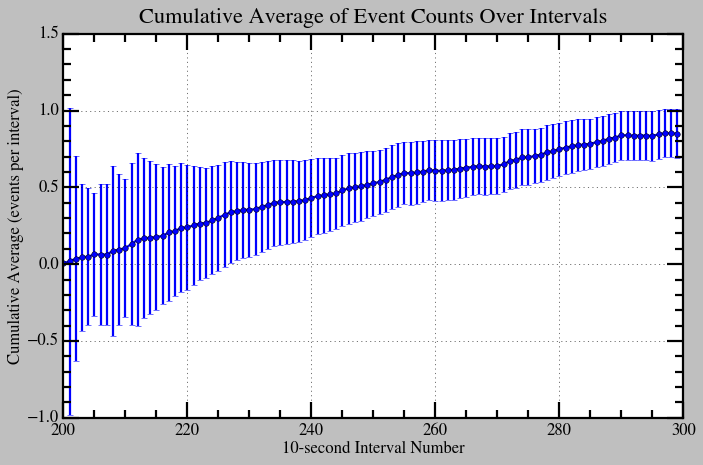

In [19]:
n_intervals = np.arange(1, len(counts)+1)
running_avg = counts.cumsum() / (counts.index + 1)
running_std = counts.expanding().std(ddof=1)
running_error = running_std / np.sqrt(n_intervals)
plt.figure(figsize=(10, 6))
plt.errorbar(running_avg.index, running_avg.values, yerr=running_error.values, fmt='o-', capsize=3)
plt.xlabel('10-second Interval Number')
plt.ylabel('Cumulative Average (events per interval)')
plt.title('Cumulative Average of Event Counts Over Intervals')
plt.grid(True)
# plt.savefig('cumulative_avg.png', dpi=300, bbox_inches='tight')
plt.show()